## RankForecasting-stint-paper-oncecar

show the forecast_samples of one car and one stint 

baseed on: 19/RankForecasting-stint-paper

stint rank prediction for paper



In [23]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.ZeroPredictor import ZeroPredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#from indycar.model.stint_predictor_fastrun import *
#import indycar.model.stint_simulator as stint
import indycar.model.stint_simulator_shortterm_pitmodel as stint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def test_pitmodel():
    stint._inlap_status = inlapmode
    
    stint.init(pitmodel)
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, model,trainid='2018')

    ret2 = {}
    
    #the simplest case, trim=0
    stint._trim = 0
    #stint._debug_carlist=[6]
    #stint._debug_carlist=[59]
    stint._debug_carlist=[]
    
    stint._force_endpit_align = False
    stint._include_endpit = True
    
    

In [43]:
def simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               datamode, loopcnt, featuremode = stint.FEATURE_STATUS,
              pitmodel = 0, model = 'oracle', inlapmode=0):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    
    stint._inlap_status = inlapmode
    
    stint.init(pitmodel)
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, model,trainid='2018')

    ret2 = {}
    
    #the simplest case, trim=0
    stint._trim = 0
    #stint._debug_carlist=[6]
    #stint._debug_carlist=[59]
    stint._debug_carlist=[]
    
    stint._force_endpit_align = False
    stint._include_endpit = True
    
    for i in range(loopcnt):
        #df, full_samples, full_tss
        ret2[i] = stint.run_simulation_stint(predictor, predictionlen, stint.freq, 
                                             _test_carno, _test_stintid, _test_loopcnt,
                                             datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i][0]
        _x = stint.get_evalret(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    #save keys
    #stint._pitmodel.save_keys('pitmodel-keys.pickle')
    
    return b, ret2

def test_pitmodelx(modelfile, testevent, runts, loopcnt=10, model='oracle'):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    if runts == 'RANK':
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                      pitmodel=modelfile, model=model)        
    else:
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                        'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile, model=model)

    #print(np.mean(acc, axis=0))
    return acc, ret

def test_pitmodel(modelfile, testevent, runts, loopcnt=10, model='oracle', inlapmode=0,featuremode = stint.FEATURE_PITAGE):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    
    lapmode = {0:'noinlap', 1:'inlap',2:'outlap'}
    
    #dataset = 'indy2013-2018%s-nocarid-context40'%('' if inlapmode==0 else '-inlapstatus')
    dataset = 'indy2013-2018-%s-%s-nocarid-context40'%(
                lapmode[inlapmode],
                'pitage' if featuremode==stint.FEATURE_PITAGE else 'nopitage'
                )
    #try:
    if True:
        if runts == 'RANK':
            acc, ret = simulation(dataset, testevent, 
                        'rank',stint.COL_RANK,'rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile, model=model, inlapmode=inlapmode,featuremode =featuremode)        
        else:
            acc, ret = simulation(dataset, testevent, 
                            'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                           2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                              pitmodel=modelfile, model=model, inlapmode=inlapmode,featuremode =featuremode)
    #except:
    #    acc, ret = [],[]
        
    #print(np.mean(acc, axis=0))
    return acc, ret

def plot_prob_forecasts_ex(ts_entry, forecast_entry, ts2, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        
        ts2.iloc[-plot_length:,0].plot(ax=axs, linewidth=1, label='CurRank')  # plot the time series
        
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.ylabel('Rank position')
        plt.xlabel('Lap')
        
        laps = range(1, 200, 20)
        
        #axs.set_xticks(laps)
        #axs.set_xticklabels([1+x*30 for x in range(7)])
        #axs.set_xticklabels(laps)
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

In [29]:
acc, ret, pret = {}, {}, {}


In [ ]:
_test_carno, _test_stintid,  _test_loopcnt = 12, 2, 100

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.76}, mae={3.10}, rmse={5.78},r2={-0.08}, 
            naive: acc={0.00}, mae={5.50}, rmse={6.71},r2={-0.09}
[[ 0.7575      3.0975      5.7786244  -0.08225025]
 [ 0.          5.5         6.70820393 -0.09256449]]


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 <a list of 22 Patch objects>)

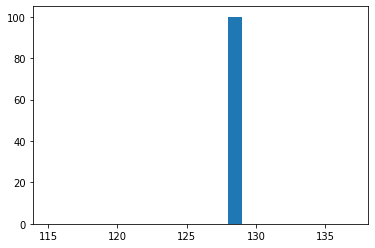

In [92]:
_test_carno, _test_stintid,  _test_loopcnt = 12, 2, 100
if True:
    tacc, tret, tpret = {}, {}, {}
    #mid = 'oracle-2018'
    #tacc[mid], tret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)
    
    
    mid2 = 'ranknet-2018-debug'
    tacc[mid2], tret[mid2] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle', 
                                   'Indy500-2018', 'TIMEDIFF', loopcnt=1)
    
df = tret[mid2][0][0]
df12_2 = df[df['carno']==12]
plt.hist(df12_2.pred_endlap,bins=range(115,138))


(array([32., 28., 18., 16.,  6.,  0.,  0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

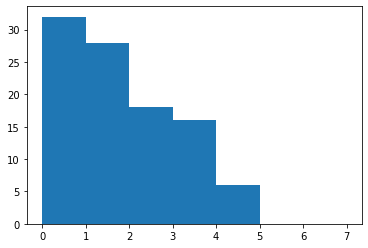

In [97]:
hdata = df12_2.pred_endrank
#plt.hist(hdata, bins=range(int(min(hdata)),int(max(hdata))))
plt.hist(hdata,bins=range(0,8))

In [98]:
np.mean(hdata), np.median(hdata)

(1.36, 1.0)

(array([ 1.,  3.,  4., 10., 10.,  5., 14., 18., 14.,  6.,  4.,  2.,  4.,
         3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 <a list of 22 Patch objects>)

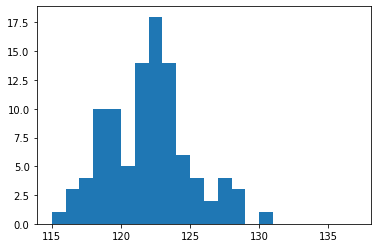

In [95]:
plt.hist(df12_2.pred_endlap,bins=range(115,138))

In [63]:
### funtional test
if True:
    tacc, tret, tpret = {}, {}, {}
    #mid = 'oracle-2018'
    #tacc[mid], tret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)
    
    
    mid2 = 'ranknet-2018-debug'
    tacc[mid2], tret[mid2] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle', 
                                   'Indy500-2018', 'TIMEDIFF', loopcnt=1)
    #,                                    inlapmode=1,featuremode =stint.FEATURE_STATUS )    
    

INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=126
pitmodel: startlap=126, laps_instint=0, cuation_laps=0,                     nextpos=154
pitmodel: startlap=154, laps_instint=0, cuation_laps=0,                     nextpos=187
pitmodel: startlap=187, laps_instint=0, cuation_laps=0,                     nextpos=219
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=127
pitmodel: startlap=127, laps_instint=0, cuation_laps=0,                     nextpos=156
pitmodel: startlap=156, laps_instint=0, cuation_laps=0,                     nextpos=185
pitmodel: startlap=185, laps_instint=0, cuation_laps=0,                     nextpos=213
pitmodel: startlap

pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=123
pitmodel: startlap=123, laps_instint=0, cuation_laps=0,                     nextpos=152
pitmodel: startlap=152, laps_instint=0, cuation_laps=0,                     nextpos=181
pitmodel: startlap=181, laps_instint=0, cuation_laps=0,                     nextpos=211
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=120
pitmodel: startlap=120, laps_instint=0, cuation_laps=0,                     nextpos=148
pitmodel: startlap=148, laps_instint=0, cuation_laps=0,                     nextpos=176
pitmodel: startlap=176, laps_instint=0, cuation_laps=0,                     nextpos=203
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=122
pitmodel: startlap=122, laps_instint=0, cuation_laps=0,                     nextpos=159
pitmodel: startlap=159, laps_instint=0, cuation_laps=0,                     nextpos=190
pitmodel: startlap=190, laps_instin

pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=117
pitmodel: startlap=117, laps_instint=0, cuation_laps=0,                     nextpos=146
pitmodel: startlap=146, laps_instint=0, cuation_laps=0,                     nextpos=178
pitmodel: startlap=178, laps_instint=0, cuation_laps=0,                     nextpos=205
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=120
pitmodel: startlap=120, laps_instint=0, cuation_laps=0,                     nextpos=152
pitmodel: startlap=152, laps_instint=0, cuation_laps=0,                     nextpos=182
pitmodel: startlap=182, laps_instint=0, cuation_laps=0,                     nextpos=212
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=105
pitmodel: startlap=105, laps_instint=0, cuation_laps=0,                     nextpos=136
pitmodel: startlap=136, laps_instint=0, cuation_laps=0,                     nextpos=164
pitmodel: startlap=164, laps_instin

pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=125
pitmodel: startlap=125, laps_instint=0, cuation_laps=0,                     nextpos=155
pitmodel: startlap=155, laps_instint=0, cuation_laps=0,                     nextpos=178
pitmodel: startlap=178, laps_instint=0, cuation_laps=0,                     nextpos=206
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=123
pitmodel: startlap=123, laps_instint=0, cuation_laps=0,                     nextpos=151
pitmodel: startlap=151, laps_instint=0, cuation_laps=0,                     nextpos=181
pitmodel: startlap=181, laps_instint=0, cuation_laps=0,                     nextpos=210
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=118
pitmodel: startlap=118, laps_instint=0, cuation_laps=0,                     nextpos=150
pitmodel: startlap=150, laps_instint=0, cuation_laps=0,                     nextpos=177
pitmodel: startlap=177, laps_instin

pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=121
pitmodel: startlap=121, laps_instint=0, cuation_laps=0,                     nextpos=149
pitmodel: startlap=149, laps_instint=0, cuation_laps=0,                     nextpos=178
pitmodel: startlap=178, laps_instint=0, cuation_laps=0,                     nextpos=209
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=118
pitmodel: startlap=118, laps_instint=0, cuation_laps=0,                     nextpos=149
pitmodel: startlap=149, laps_instint=0, cuation_laps=0,                     nextpos=178
pitmodel: startlap=178, laps_instint=0, cuation_laps=0,                     nextpos=207
pitmodel: startlap=93, laps_instint=0, cuation_laps=0,                     nextpos=121
pitmodel: startlap=121, laps_instint=0, cuation_laps=0,                     nextpos=150
pitmodel: startlap=150, laps_instint=0, cuation_laps=0,                     nextpos=176
pitmodel: startlap=176, laps_instin

(array([ 0.,  2.,  3.,  5.,  5.,  9., 12., 17., 15., 14.,  7.,  2.,  3.,
         2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 <a list of 22 Patch objects>)

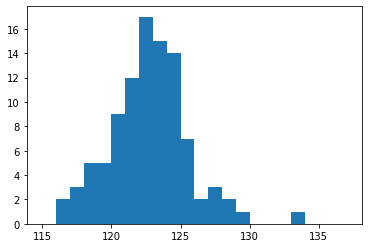

In [82]:
df = tret[mid2][0][0]
df12_2 = df[df['carno']==12]
plt.hist(df12_2.endlap,bins=range(115,138))

In [90]:
df12_2

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap
1,12,93,0.0,1.0,1.0,1,0.0,0.0,0,126
5,12,93,0.0,1.0,1.0,1,0.0,0.0,0,127
9,12,93,0.0,1.0,1.0,1,1.0,1.0,1,123
13,12,93,0.0,1.0,1.0,1,1.0,1.0,1,122
17,12,93,0.0,1.0,1.0,1,2.0,2.0,1,121
...,...,...,...,...,...,...,...,...,...,...
381,12,93,0.0,1.0,1.0,1,1.0,1.0,1,121
385,12,93,0.0,1.0,1.0,1,2.0,2.0,1,118
389,12,93,0.0,1.0,1.0,1,0.0,0.0,0,121
393,12,93,0.0,1.0,1.0,1,0.0,0.0,0,124


(array([45., 31., 12., 12.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

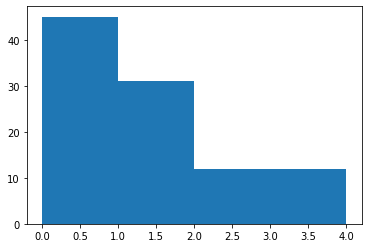

In [89]:
hdata = df12_2.pred_endrank
#plt.hist(hdata, bins=range(int(min(hdata)),int(max(hdata))))
plt.hist(hdata,bins=range(0,5))

In [91]:
np.median(hdata),np.mean(hdata)

(1.0, 0.93)

(array([ 3.,  0.,  1.,  2.,  6., 22., 26., 16.,  8.,  8.,  2.,  6.]),
 array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 <a list of 12 Patch objects>)

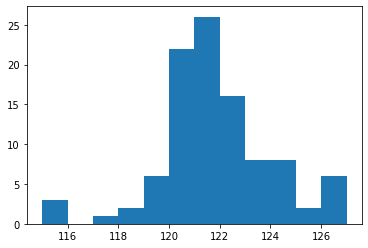

In [56]:
df = tret[mid2][0][0]
df12_2 = df[df['carno']==12]
plt.hist(df12_2.endlap,bins=range(115,128))

In [64]:
stint.init('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle')
pits = stint.debug_pitmodel(93,12,0,0,10000)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)


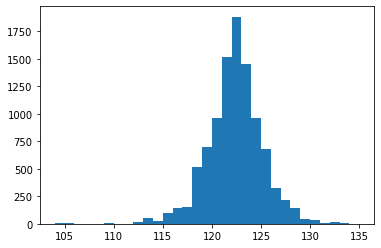

In [66]:
hret = plt.hist(pits,bins=range(min(pits),max(pits)))

In [73]:
np.argmax(hret[0])

18

In [74]:
hret[1][18]

122

In [80]:
#hret[1].shape, hret[0].shape
hret

(array([  11.,    4.,    0.,    0.,    0.,    8.,    0.,    0.,   12.,
          55.,   28.,   96.,  143.,  154.,  514.,  697.,  958., 1517.,
        1884., 1450.,  966.,  679.,  328.,  220.,  147.,   46.,   31.,
          11.,   20.,    9.,    0.]),
 array([104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135]),
 <a list of 31 Patch objects>)

In [79]:
pitsa = np.array(pits)
np.sum(pitsa==122)

1884

(array([ 350.,    0.,  203.,  275.,  797., 1766., 2388., 1517., 1119.,
         822.,   96.,  285.,  301.]),
 array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128]),
 <a list of 13 Patch objects>)

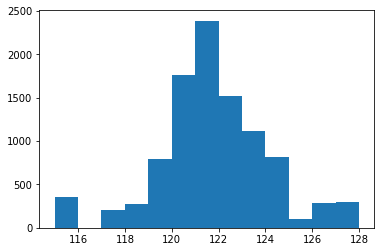

In [62]:
plt.hist(pits,bins=range(min(pits),max(pits)))

(array([ 4.,  1., 10., 16., 21., 28.,  8.,  5.,  5.,  2.]),
 array([71. , 72.4, 73.8, 75.2, 76.6, 78. , 79.4, 80.8, 82.2, 83.6, 85. ]),
 <a list of 10 Patch objects>)

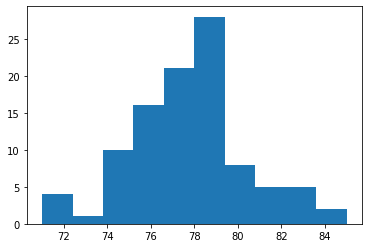

In [50]:
df = tret[mid2][0][0]
df12_1 = df[df['carno']==12]
plt.hist(df12_1.endlap)

(array([ 4.,  1., 10., 15., 25., 21., 16.,  5.,  0.,  3.]),
 array([53. , 54.4, 55.8, 57.2, 58.6, 60. , 61.4, 62.8, 64.2, 65.6, 67. ]),
 <a list of 10 Patch objects>)

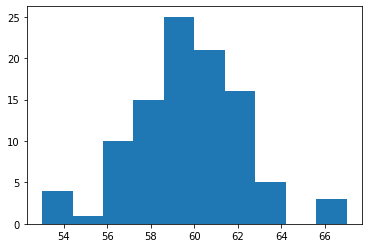

In [47]:
plt.hist(df12.endlap)

In [41]:
_test_stintid = 1
tacc[mid2], tret[mid2] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 
                                   'Indy500-2018', 'TIMEDIFF', loopcnt=1)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
start pitlap: 49
--------- start update_onets: 49 ----------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
--------- after update_onets: 49 ----------
[0. 0.

simulation done: 31
startlap=49, total=200, pitstop status = True, nextpit=93, nextpit_pred=76
start pitlap: 49
--------- start update_onets: 49 ----------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
--------- after update_onets: 49 ----------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [42]:
df = tret[mid2][0][0]
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap
5,12,49,5.0,0.0,-5.0,-1,5.0,0.0,0,80
26,12,49,5.0,0.0,-5.0,-1,1.0,-4.0,-1,78
47,12,49,5.0,0.0,-5.0,-1,8.0,3.0,1,76
68,12,49,5.0,0.0,-5.0,-1,11.0,6.0,1,75
89,12,49,5.0,0.0,-5.0,-1,4.0,-1.0,-1,78
110,12,49,5.0,0.0,-5.0,-1,8.0,3.0,1,76
131,12,49,5.0,0.0,-5.0,-1,6.0,1.0,1,77
152,12,49,5.0,0.0,-5.0,-1,4.0,-1.0,-1,79
173,12,49,5.0,0.0,-5.0,-1,8.0,3.0,1,76
194,12,49,5.0,0.0,-5.0,-1,9.0,4.0,1,74


In [38]:
df = tret[mid][0][0]
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap
2,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
10,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
18,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
26,12,31,3.0,5.0,2.0,1,1.0,-2.0,-1,49
34,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
42,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
50,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
58,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1,49
66,12,31,3.0,5.0,2.0,1,1.0,-2.0,-1,49
74,12,31,3.0,5.0,2.0,1,1.0,-2.0,-1,49


In [19]:
full_samples,full_tss, nextlap = tret[mid][0][1], tret[mid][0][2], tret[mid][0][3]

In [20]:
nextlap

49

In [22]:
full_samples[12][nextlap]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  4., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [11]:
full_samples,full_tss, nextlap = tret[mid][0][1], tret[mid][0][2], tret[mid][0][3]
testcar = _test_carno
freq = '1min'
start = pd.Timestamp("01-01-2019", freq=freq) 
fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)
index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
ts = pd.DataFrame(index = index, data = full_tss[testcar])

tss2 = np.zeros_like(full_tss[testcar])
tss2[2:] = full_tss[testcar][:-2]
index2 = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))

ts2 = pd.DataFrame(index = index2, data = tss2)

plot_prob_forecasts_ex([ts], [fc], ts2,'output-car12')

{'oracle-2018': []}

### start experiments

In [4]:
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}
for year in ['2018','2019']:
    for runts in ['TIMEDIFF','RANK']:
        for fmode in [stint.FEATURE_PITAGE, stint.FEATURE_STATUS]:
            for lapmode in [0,1,2]:
                mid = 'oracle-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
                acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-%s'%year, runts, loopcnt=3,inlapmode=lapmode,featuremode = fmode)
                #if acc[mid] != []:
                #    pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
                #else:
                #    pret[mid] = []


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.73}, mae={3.11}, rmse={4.79},r2={-0.24}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.69}, mae={3.19}, rmse={4.87},r2={-0.29}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.70}, mae={3.17}, rmse={4.84},r2={-0.19}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.70723104  3.15343915  4.83252122 -0.24008215]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.68}, mae={3.39}, rmse={5.10},r2={-0.29}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.67}, mae={3.40}, rmse={5.02},r2={-0.34}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.69}, mae={3.31}, rmse={4.97},r2={-0.40}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.67730496  3.36879433  5.02908453 -0.34263119]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.70}, mae={3.22}, rmse={4.92},r2={-0.35}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.27}, rmse={5.01},r2={-0.43}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.32}, rmse={4.99},r2={-0.37}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.68783069  3.26984127  4.97281091 -0.38313951]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.68}, mae={3.52}, rmse={5.37},r2={-0.33}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.68}, mae={3.54}, rmse={5.25},r2={-0.37}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.67}, mae={3.60}, rmse={5.45},r2={-0.45}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.67730496  3.55141844  5.35897401 -0.38543364]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={1.00}, mae={1.00}, rmse={1.41},r2={-7.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={0.50}, rmse={0.71},r2={0.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={1.00}, rmse={1.41},r2={-7.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
[[ 1.          0.83333333  1.1785113  -4.66666667]
 [ 0.          1.5         1.58113883  0.9       ]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


loading model...done!, ctx:gpu(0)
model: acc={0.69}, mae={3.39}, rmse={5.05},r2={-0.52}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.69}, mae={3.60}, rmse={5.45},r2={-0.29}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.68}, mae={3.41}, rmse={5.08},r2={-0.38}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.68783069  3.46737213  5.19239603 -0.39800016]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.64}, mae={3.57}, rmse={5.26},r2={-0.99}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.65}, mae={3.71}, rmse={5.34},r2={-0.86}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.67}, mae={3.60}, rmse={5.21},r2={-0.93}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.65602837  3.62411348  5.26876319 -0.92471326]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.58}, mae={3.54}, rmse={5.08},r2={-3.50}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.54}, mae={3.68}, rmse={5.27},r2={-3.59}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.63}, mae={3.37}, rmse={5.03},r2={-4.21}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.58553792  3.5308642   5.1234845  -3.76861834]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.65}, mae={3.55}, rmse={5.21},r2={-3.40}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.64}, mae={3.38}, rmse={4.97},r2={-2.59}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.62}, mae={3.66}, rmse={5.26},r2={-3.20}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.63652482  3.53014184  5.14650584 -3.06341277]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={1.00}, mae={2.50}, rmse={3.54},r2={-2.12}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={1.50}, rmse={2.12},r2={-3.50}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={2.00}, rmse={2.83},r2={-2.56}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
[[ 1.          2.          2.82842712 -2.72685185]
 [ 0.          1.5         1.58113883  0.9       ]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

In [5]:
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}
for year in ['2018','2019']:
    for runts in ['TIMEDIFF','RANK']:
        for fmode in [stint.FEATURE_PITAGE, stint.FEATURE_STATUS]:
            for lapmode in [0,1,2]:
                mid = 'pitmodel-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
                acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 
                                    'Indy500-%s'%year, runts, loopcnt=3,inlapmode=lapmode,featuremode = fmode)
                #if acc[mid] != []:
                #    pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
                #else:
                #    pret[mid] = []

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.55}, mae={4.01}, rmse={5.79},r2={-1.30}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.58}, mae={3.80}, rmse={5.65},r2={-0.97}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.59}, mae={3.83}, rmse={5.76},r2={-1.10}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.57319224  3.88007055  5.73427669 -1.12056705]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.55}, mae={4.11}, rmse={5.89},r2={-0.93}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.59}, mae={4.07}, rmse={5.70},r2={-0.87}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.57}, mae={4.11}, rmse={5.86},r2={-1.26}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.56914894  4.09751773  5.81495358 -1.02092739]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.54}, mae={4.01}, rmse={5.78},r2={-1.12}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.54}, mae={4.02}, rmse={5.75},r2={-1.11}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.61}, mae={3.88}, rmse={5.69},r2={-1.19}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.56613757  3.96825397  5.73999623 -1.14009759]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.58}, mae={4.20}, rmse={6.16},r2={-0.88}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.52}, mae={4.37}, rmse={6.28},r2={-1.15}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.54}, mae={4.26}, rmse={6.38},r2={-1.07}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.54787234  4.2748227   6.271653   -1.03497465]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.63}, mae={3.56}, rmse={5.30},r2={-1.27}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.62}, mae={3.77}, rmse={5.41},r2={-1.02}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.61}, mae={3.80}, rmse={5.51},r2={-1.21}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.62081129  3.71075838  5.40584204 -1.16668121]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.63}, mae={3.84}, rmse={5.65},r2={-1.62}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.62}, mae={3.99}, rmse={5.84},r2={-1.58}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.61}, mae={3.87}, rmse={5.62},r2={-1.23}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.61879433  3.90248227  5.7014732  -1.47645742]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.53}, mae={3.72}, rmse={5.24},r2={-3.67}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.54}, mae={3.73}, rmse={5.27},r2={-4.49}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.53}, mae={3.75}, rmse={5.33},r2={-3.63}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.5361552   3.7319224   5.28004124 -3.92867215]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.59}, mae={3.88}, rmse={5.47},r2={-4.46}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.57}, mae={3.74}, rmse={5.38},r2={-3.00}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.57}, mae={3.84}, rmse={5.45},r2={-3.42}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.57446809  3.82092199  5.43238235 -3.62655648]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4


In [6]:
acc

{'oracle-TIMEDIFF-2018-noinlap-pitage': array([[[ 0.73015873,  3.10582011,  4.78810254, -0.24021232],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.18518519,  4.87407568, -0.2891362 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.7037037 ,  3.16931217,  4.83538544, -0.19089792],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]]]),
 'oracle-TIMEDIFF-2018-inlap-pitage': array([[[ 0.67553191,  3.39361702,  5.09693274, -0.29255276],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]],
 
        [[ 0.67021277,  3.39893617,  5.01752249, -0.34025196],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]],
 
        [[ 0.68617021,  3.31382979,  4.97279835, -0.39508884],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]]]),
 'oracle-TIMEDIFF-2018-outlap-pitage': [],
 'oracle-TIMEDIFF-2018-noinlap-nopitage': array([[[ 0.6984127 ,  3.21693122,  4.92268263, -0.34985685],
   

In [7]:
sys.exit(0)

SystemExit: 0

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print(np.mean(acc['oracle-TIMEDIFF-2018-inlap-nopitage'], axis=0))
print(np.mean(acc['oracle-TIMEDIFF-2019-inlap-nopitage'], axis=0))

In [ ]:
print(np.mean(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0))
print(np.mean(acc['pitmodel-TIMEDIFF-2019-inlap-nopitage'], axis=0))

In [ ]:
df1 =ret['oracle-RANK-2019-noinlap-nopitage'][0]
df2 =ret['pitmodel-RANK-2019-noinlap-nopitage'][0]
print('2019: oracle:%d, pitmodel:%d'%(len(df1),len(df2)))

In [19]:
def get_best(pitmodel=True, verbose=False):
    best_acc = {2018:[0, ''], 2019:[0,'']}
    best_mae = {2018:[100, ''], 2019:[100,'']}
    for model in ret.keys():
        if model.find('pitmodel')==0:
            if len(ret[model]) > 0:
                oracle = model.replace('pitmodel','oracle')
                if verbose:
                    print('model:',(oracle))
                acc_oracle = np.mean(acc[oracle], axis=0)
                if verbose:
                    print(acc_oracle)

                if verbose:
                    print('model:',(model))
                acc_model = np.mean(acc[model], axis=0)
                if verbose:
                    print(acc_model)

                if model.find('2018') > 0:
                    year = 2018
                else:
                    year = 2019
                    
                if pitmodel:
                    test_model = acc_model
                    modelname = model
                else:
                    test_model = acc_oracle
                    modelname = oracle
                    
                #mae
                if test_model[0, 0] > best_acc[year][0]:
                    best_acc[year][0] = test_model[0, 0]
                    best_acc[year][1] = modelname

                if test_model[0, 1] < best_mae[year][0]:
                    best_mae[year][0] = test_model[0, 1]
                    best_mae[year][1] = modelname
                
    #print('mae',best_mae)
    #print('acc',best_acc)                
    return best_acc, best_mae
                


In [20]:
get_best(pitmodel=True, verbose=False)

({2018: [0.6208112874779541, 'pitmodel-RANK-2018-noinlap-pitage'],
  2019: [0.5162790697674419, 'pitmodel-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.710758377425044, 'pitmodel-RANK-2018-noinlap-pitage'],
  2019: [4.0060060060060065, 'pitmodel-RANK-2019-inlap-nopitage']})

In [21]:
get_best(pitmodel=False, verbose=False)

({2018: [0.7072310405643739, 'oracle-TIMEDIFF-2018-noinlap-pitage'],
  2019: [0.627906976744186, 'oracle-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.1534391534391535, 'oracle-TIMEDIFF-2018-noinlap-pitage'],
  2019: [3.578294573643411, 'oracle-TIMEDIFF-2019-noinlap-nopitage']})

In [8]:
best_acc = {2018:[0, ''], 2019:[0,'']}
best_mae = {2018:[100, ''], 2019:[100,'']}
for model in ret.keys():
    if model.find('pitmodel')==0:
        if len(ret[model]) > 0:
            oracle = model.replace('pitmodel','oracle')
            print('model:',(oracle))
            acc_oracle = np.mean(acc[oracle], axis=0)
            print(acc_oracle)
            
            print('model:',(model))
            acc_model = np.mean(acc[model], axis=0)
            print(acc_model)
            
            if model.find('2018') > 0:
                year = 2018
            else:
                year = 2019
            
            #mae
            if acc_model[0, 0] > best_acc[year][0]:
                best_acc[year][0] = acc_model[0, 0]
                best_acc[year][1] = model
                
            if acc_model[0, 1] < best_mae[year][0]:
                best_mae[year][0] = acc_model[0, 1]
                best_mae[year][1] = model
                
                
print('mae',best_mae)
print('acc',best_acc)

model: oracle-TIMEDIFF-2018-noinlap-pitage
[[ 0.70723104  3.15343915  4.83252122 -0.24008215]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: pitmodel-TIMEDIFF-2018-noinlap-pitage
[[ 0.57319224  3.88007055  5.73427669 -1.12056705]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: oracle-TIMEDIFF-2018-inlap-pitage
[[ 0.67730496  3.36879433  5.02908453 -0.34263119]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]
model: pitmodel-TIMEDIFF-2018-inlap-pitage
[[ 0.56914894  4.09751773  5.81495358 -1.02092739]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]
model: oracle-TIMEDIFF-2018-noinlap-nopitage
[[ 0.68783069  3.26984127  4.97281091 -0.38313951]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: pitmodel-TIMEDIFF-2018-noinlap-nopitage
[[ 0.56613757  3.96825397  5.73999623 -1.14009759]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: oracle-TIMEDIFF-2018-inlap-nopitage
[[ 0.67730496  3.55141844  5.35897401 -0.38543364]
 [ 0.10638298  4.2393617

### test

In [3]:
tacc, tret = {}, {}

In [4]:
mid = 'oracle-2018'
tacc[mid], tret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)


NameError: name 'test_pitmodel' is not defined

In [ ]:
mid = 'ranknet-2018-debug'
tacc[mid], tret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 
                                   'Indy500-2018', 'TIMEDIFF', loopcnt=1,
                                    inlapmode=1,featuremode =stint.FEATURE_STATUS )


In [ ]:
allpits, pitmat, maxlap = stint.get_pitlaps(verbose=True)
#print(len(allpits), maxlap)
nextpit, maxnext = stint.get_nextpit(pitmat, 30)

print(nextpit, maxnext)

In [ ]:
len(pitmat)

In [ ]:
pitmat

In [23]:
df=ret['pitmodel-RANK-2018-noinlap-pitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,13,28,20.0,12.0,-8.0,-1,14.0,-6.0,-1
1,14,29,10.0,1.0,-9.0,-1,7.0,-3.0,-1
2,59,29,32.0,22.0,-10.0,-1,28.0,-4.0,-1
3,3,30,10.0,4.0,-6.0,-1,7.0,-3.0,-1
4,20,30,7.0,0.0,-7.0,-1,0.0,-7.0,-1
...,...,...,...,...,...,...,...,...,...
184,25,195,16.0,14.0,-2.0,-1,13.0,-3.0,-1
185,59,195,21.0,21.0,0.0,0,21.0,0.0,0
186,60,195,17.0,15.0,-2.0,-1,15.0,-2.0,-1
187,19,196,15.0,18.0,3.0,1,17.0,2.0,1


In [24]:
df=ret['oracle-TIMEDIFF-2019-inlap-pitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,10,7,31.0,12.0,-19.0,-1,30.0,-1.0,-1
1,24,7,30.0,23.0,-7.0,-1,31.0,1.0,1
2,98,7,27.0,29.0,2.0,1,31.0,4.0,1
3,22,31,15.0,5.0,-10.0,-1,2.0,-13.0,-1
4,2,33,27.0,18.0,-9.0,-1,14.0,-13.0,-1
...,...,...,...,...,...,...,...,...,...
217,3,184,21.0,17.0,-4.0,-1,21.0,0.0,0
218,24,184,17.0,18.0,1.0,1,19.0,2.0,1
219,48,184,20.0,19.0,-1.0,-1,20.0,0.0,0
220,60,184,18.0,20.0,2.0,1,17.0,-1.0,-1


In [25]:

df=ret['oracle-RANK-2019-noinlap-nopitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,10,7,31.0,12.0,-19.0,-1,31.0,0.0,0
1,24,7,30.0,23.0,-7.0,-1,30.0,0.0,0
2,98,7,27.0,29.0,2.0,1,27.0,0.0,0
3,22,31,15.0,5.0,-10.0,-1,0.0,-15.0,-1
4,2,33,27.0,18.0,-9.0,-1,12.0,-15.0,-1
...,...,...,...,...,...,...,...,...,...
210,3,184,21.0,17.0,-4.0,-1,21.0,0.0,0
211,24,184,17.0,18.0,1.0,1,16.0,-1.0,-1
212,48,184,20.0,19.0,-1.0,-1,20.0,0.0,0
213,60,184,18.0,20.0,2.0,1,18.0,0.0,0


In [28]:
np.mean(acc['oracle-TIMEDIFF-2019-noinlap-pitage'],axis=0)

array([[ 0.61085271,  3.87751938,  5.71170474, -0.13350819],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [29]:
np.mean(acc['pitmodel-RANK-2018-noinlap-pitage'],axis=0)

array([[ 0.62081129,  3.71075838,  5.40584204, -1.16668121],
       [ 0.1005291 ,  4.10582011,  5.523399  ,  0.56876669]])

In [33]:
np.mean(acc['pitmodel-TIMEDIFF-2019-noinlap-nopitage'],axis=0)

array([[ 0.51627907,  4.5875969 ,  6.50518216, -0.87430609],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [37]:
np.mean(acc['pitmodel-RANK-2019-noinlap-pitage'],axis=0)

array([[ 0.49302326,  4.42325581,  6.37255417, -0.89674152],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [36]:
np.mean(acc['pitmodel-RANK-2019-inlap-nopitage'],axis=0)

array([[ 0.45795796,  4.00600601,  6.0306237 , -1.94041352],
       [ 0.18018018,  4.03603604,  6.25292724,  0.46046139]])

In [ ]:
correct = df[df['sign']==df['pred_sign']] 
acc = len(correct)/len(df)
acc

In [ ]:
stint.get_evalret(df)

In [ ]:
ret ={ }
ret['oracle'] = df
ret['curtrack'] = stint.run_simulation(predictor, 2, stint.freq, datamode=stint.MODE_TESTCURTRACK )

In [ ]:
stint.get_evalret(ret['curtrack'])

In [ ]:
ret['zerotrack'] = stint.run_simulation(predictor, 2, stint.freq, datamode=stint.MODE_TESTZERO )

In [ ]:
stint.get_evalret(ret['zerotrack'])

### test sim by pred

In [ ]:
def simulation2(datasetid, testevent, taskid, runts, expid, predictionlen, datamode, loopcnt, featuremode = stint.FEATURE_STATUS):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    stint.init()
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, 'oracle',trainid='2018')

    ret2 = {}
    for i in range(loopcnt):
        ret2[i] = stint.run_simulation_pred(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i]
        _x = stint.get_evalret(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    return b

In [ ]:
accret = simulation('indy2013-2018-nocarid', 'Indy500-2018', 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY, 3)

In [ ]:
accret = simulation('indy2013-2018-nocarid', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,3)


In [ ]:
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_TESTCURTRACK,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_TESTZERO,5)

In [ ]:
accret = simulation('indy2013-2018-pitage-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5, featuremode = stint.FEATURE_PITAGE)

In [ ]:
accret = simulation('indy2013-2018', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
accret = simulation('indy2013-2018', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
### pitmodel -- top8
accret = simulation('indy2013-2018', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)
accret = simulation('indy2013-2018', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
### pitmodel -- top8
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

### sim pred

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()

#stint._dataset_id = 'indy2013-2018'
stint._test_event = 'Indy500-2018'
#_test_event = 'Indy500-2019'

#stint._dataset_id = 'indy2013-2018-nocarid-context40'
#stint._feature_mode = stint.FEATURE_STATUS
stint._dataset_id = 'indy2013-2018-pitage-nocarid-context40'
stint._feature_mode = stint.FEATURE_PITAGE

stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')
df2 = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE_LAPONLY)
stint.get_evalret(df2)
df3 = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)
stint.get_evalret(df3)

In [ ]:
df2[df2['carno']==12]

In [ ]:
df2

In [ ]:
stint.get_evalret(df2)

In [ ]:
ret2 = {}
for i in range(10):
    ret2[i] = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE_LAPONLY)
    
acc = []
for i in ret2.keys():
    df = ret2[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
df[df['carno']==12]

In [ ]:
stint.get_evalret(df)

In [ ]:
acc = []
for i in ret.keys():
    df = ret[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

In [ ]:
a = [(1,2,3),(2,3,4)]
np.array(a)

In [ ]:
len(ret)

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()
stint._dataset_id = 'indy2013-2018-nocarid-context40'
stint._test_event = 'Indy500-2019'
#_test_event = 'Indy500-2019'

stint._feature_mode = stint.FEATURE_STATUS
stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
stint.get_evalret(df)

In [ ]:
ret2 = {}
for i in range(10):
    ret2[i] = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
acc = []
for i in ret2.keys():
    df = ret2[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

### debug

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()
stint._dataset_id = 'indy2013-2018-nocarid-context40'
stint._test_event = 'Indy500-2019'
#_test_event = 'Indy500-2019'

stint._feature_mode = stint.FEATURE_STATUS
stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
stint.get_evalret(df)

### difference ? oracle .vs. pred

In [ ]:
#df, df2
df

In [ ]:
df2

In [ ]:
oracle = df[['carno','startlap']].values
pred =  df2[['carno','startlap']].values

In [ ]:
a = set(['%s-%s'%(x[0],x[1]) for x in oracle])
b = set(['%s-%s'%(x[0],x[1]) for x in  pred])
a -b

In [ ]:
df[df['carno']==3]

In [ ]:
df2[df2['carno']==3]

In [ ]:
_, data2018, _ = stint.load_data('Indy500-2018')
data2018[data2018['completed_laps']==200]

In [ ]:
topK = data2018[data2018['completed_laps']==200]['car_number'].values
topK

In [ ]:
topK_df = df[df['carno'].isin(topK[:5])]
stint.get_evalret(topK_df)

In [ ]:
len(topK_df)

In [ ]:
topK_df2 = df2[df2['carno'].isin(topK[:5])]
stint.get_evalret(topK_df2)

In [ ]:
len(topK_df2)

### check the dataset

In [ ]:
df = ret['oracle-2018']

In [ ]:
df = df[0]
df[df['carno']==6]

In [ ]:
len(df)

In [ ]:
dftemp = df[['carno','startlap', 'startrank','endrank']].sort_values(['carno','startlap'])
test = dftemp[['carno','startlap', 'startrank','endrank']].values.astype(int)
dfout = pd.DataFrame(test, columns =['carno','startlap', 'startrank','endrank'])
dfout.to_csv('test_db_ranknet2.csv')

In [ ]:
df = ret['ranknet-2018'][0]
df[df['carno']==6]

In [ ]:
len(df)

In [ ]:
ret['ranknet-timediff-2019']

In [ ]:
ret.keys()

In [ ]:
df=ret['oracle-2018'][0]
df.to_csv('result-stint')

In [ ]:
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==12]

In [ ]:
df

In [ ]:
df[df['carno']==12]

In [ ]:
df = ret['oracle-TIMEDIFF-2018-inlap-pitage'][0]
df[df['carno']==12]

In [ ]:
df = ret['pitmodel-TIMEDIFF-2018-outlap-nopitage'][0]
df[df['carno']==12]

In [ ]:
stint._inlap_status = 0

stint.init('oracle')

In [ ]:
accx, retx = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)
df_oracle_2018 = retx[0]

In [ ]:
stint.get_evalret(df_oracle_2018)

In [ ]:
accx2, retx2 = test_pitmodel('oracle', 'Indy500-2019', 'TIMEDIFF', loopcnt=1)
df_oracle_2019 = retx2[0]

In [ ]:
def neweval(df_refer, mid):
    dfml = df_refer
    dfranknet = ret[mid][0]
    carlist = set(list(dfml['carno'].values))
    dfpits = []
    for car in carlist:
        pitlaps = dfml[dfml['carno']==car].startlap
        dfpits.append(dfranknet[(dfranknet['carno']==car) & (dfranknet['startlap'].isin(pitlaps))])

    df_ranknet = pd.concat(dfpits)
    accret = stint.get_evalret(df_ranknet)
    
    return df_ranknet, accret


def neweval2(df_refer, df2):
    dfml = df_refer
    dfranknet = df2
    carlist = set(list(dfml['carno'].values))
    dfpits = []
    for car in carlist:
        pitlaps = dfml[dfml['carno']==car].startlap
        dfpits.append(dfranknet[(dfranknet['carno']==car) & (dfranknet['startlap'].isin(pitlaps))])

    df_ranknet = pd.concat(dfpits)
    accret = stint.get_evalret(df_ranknet)
    
    return df_ranknet, accret

In [ ]:
dfn, accn = {} ,{}

In [ ]:
mid = 'oracle-TIMEDIFF-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-TIMEDIFF-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-RANK-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-RANK-2018-inlap-nopitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-TIMEDIFF-2018-inlap-nopitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'oracle-TIMEDIFF-2018-inlap-pitage'
dfn[mid][dfn[mid]['carno']==12]

In [ ]:
df_oracle_2018[df_oracle_2018['carno']==12]

In [ ]:
acc2, ret2 = {},{}

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'oracle-timediff-2018-inlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1,
                                     inlapmode=1,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-inlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=1,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-noinlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=0,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-noinlap-pitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=0,featuremode = stint.FEATURE_PITAGE)

In [ ]:
df= ret2[mid][0]
df[df['carno']==59]

In [ ]:
df

In [ ]:
neweval2(df, df_oracle_2018)

In [ ]:
neweval2(df_oracle_2018,ret2[mid][0])

In [ ]:
neweval2(df_oracle_2018,df_oracle_2018)

In [ ]:
df_oracle_2018[140:]

In [38]:
### investigate the blackhorse car 27
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==27]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
26,27,33,19.0,21.0,2.0,1,21.0,2.0,1
50,27,49,21.0,21.0,0.0,0,13.0,-8.0,-1
93,27,94,21.0,17.0,-4.0,-1,20.0,-1.0,-1
126,27,129,17.0,8.0,-9.0,-1,9.0,-8.0,-1
167,27,173,8.0,3.0,-5.0,-1,3.0,-5.0,-1


In [52]:
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
11,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1
39,12,49,5.0,0.0,-5.0,-1,3.0,-2.0,-1
89,12,93,0.0,1.0,1.0,1,1.0,1.0,1
121,12,128,1.0,7.0,6.0,1,1.0,0.0,0
160,12,170,7.0,0.0,-7.0,-1,0.0,-7.0,-1


In [53]:
top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=4.23, mae=3.02, r2=0.11


(3.020408163265306, 4.233009254294015, 0.11437276133229024)

In [55]:
#top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
top10 = [12, 20, 9, 27, 28]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=3.47, mae=2.52, r2=0.31


(2.52, 3.4698703145794942, 0.30963302752293576)

In [56]:
df = ret['pitmodel-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==27]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
26,27,33,19.0,21.0,2.0,1,26.0,7.0,1
50,27,49,21.0,21.0,0.0,0,17.0,-4.0,-1
93,27,94,21.0,17.0,-4.0,-1,21.0,0.0,0
126,27,129,17.0,8.0,-9.0,-1,16.0,-1.0,-1
167,27,173,8.0,3.0,-5.0,-1,3.0,-5.0,-1


In [47]:
car27 = df[df['carno']==27]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=4.92, mae=4.20, r2=-0.36


(4.2, 4.919349550499537, -0.3565022421524666)

In [48]:
car27 = df[df['carno']==12]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=3.85, mae=3.20, r2=-3.30


(3.2, 3.847076812334269, -3.3023255813953494)

In [49]:
car27 = df
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=5.79, mae=4.01, r2=-1.30


(4.01058201058201, 5.790888665342439, -1.297248783182022)

In [50]:
len(df)

189

In [58]:
top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=6.07, mae=4.37, r2=-1.14


(4.36734693877551, 6.074369035848371, -1.139696647666892)

In [57]:
#top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
top10 = [12, 20, 9, 27, 28]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=5.35, mae=3.72, r2=-0.62


(3.72, 5.347896782848375, -0.6226397966594044)

In [46]:
import math
from sklearn import metrics
def evaluate(test_y, pred_y):
    mae = metrics.mean_absolute_error(test_y, pred_y) 
    rmse = math.sqrt(metrics.mean_squared_error(test_y, pred_y))
    r2 = metrics.r2_score(test_y, pred_y)
    print('rmse=%.2f, mae=%.2f, r2=%.2f'%(rmse, mae, r2))
    return mae,rmse, r2